# Goals

The purpose of this lab is to give you a chance to practice using NumPy for manipulating arrays and making plots with matplotlib.

Along the way, you'll see some of the ideas about neural networks reinforced.

# Example

We will work with an example of using logistic regression to predict whether someone will develop coronary heart disease (chd, our response variable) based on characteristics like their age, blood pressure, ldl cholesterol level, presence/absence of CHD in their family history, and so on.

# Importing Python Modules

These modules extend the base functionality in Python for working with data, making plots, and fitting neural network models.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(9533)
from keras import models
from keras import layers
from keras import initializers
from keras import optimizers

Using TensorFlow backend.


# Reading in the data, initial set up
For now, we want to concentrate on lower level calculations using NumPy; we'll talk more about using Pandas later.  That means I will do some preliminary data manipulation for us so that we can get on to today's topics, but we'll come back and talk about this kind of thing in more detail later :)  

The code below reads in the data and takes a quick look at the first few rows.

In [0]:
saheart = pd.read_csv("http://www.evanlray.com/data/ESL/SAheart.data.txt").iloc[:, 1:11]
print(saheart.head())
print("shape (rows, columns) = " + str(saheart.shape))
print("column names are: " + str(saheart.columns))

   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52    1
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63    1
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46    0
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58    1
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49    1
shape (rows, columns) = (462, 10)
column names are: Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity',
       'alcohol', 'age', 'chd'],
      dtype='object')


We need to convert famhist to a one-hot encoding, otherwise known as indicator or dummy variable.  The Pandas function `get_dummies` can do this for us:

In [0]:
saheart = pd.get_dummies(saheart, drop_first = True)
print(saheart.head())

   sbp  tobacco   ldl  adiposity  ...  alcohol  age  chd  famhist_Present
0  160    12.00  5.73      23.11  ...    97.20   52    1                1
1  144     0.01  4.41      28.61  ...     2.06   63    1                0
2  118     0.08  3.48      32.28  ...     3.81   46    0                1
3  170     7.50  6.41      38.03  ...    24.26   58    1                1
4  134    13.60  3.50      27.78  ...    57.34   49    1                1

[5 rows x 10 columns]


We are now ready to extract the data to NumPy arrays using the `to_numpy` function:

In [0]:
# X will include all columns other than the response, chd;
# we drop that column and convert the others to numpy
X = saheart.drop('chd', axis = 1).to_numpy()
print(X[0:5, ])

# y will include only the chd column
y = saheart['chd'].to_numpy()
y = y.reshape((y.shape[0], 1))
print(y[0:5, :])

[[1.600e+02 1.200e+01 5.730e+00 2.311e+01 4.900e+01 2.530e+01 9.720e+01
  5.200e+01 1.000e+00]
 [1.440e+02 1.000e-02 4.410e+00 2.861e+01 5.500e+01 2.887e+01 2.060e+00
  6.300e+01 0.000e+00]
 [1.180e+02 8.000e-02 3.480e+00 3.228e+01 5.200e+01 2.914e+01 3.810e+00
  4.600e+01 1.000e+00]
 [1.700e+02 7.500e+00 6.410e+00 3.803e+01 5.100e+01 3.199e+01 2.426e+01
  5.800e+01 1.000e+00]
 [1.340e+02 1.360e+01 3.500e+00 2.778e+01 6.000e+01 2.599e+01 5.734e+01
  4.900e+01 1.000e+00]]
[[1]
 [1]
 [0]
 [1]
 [1]]


I will do one more step for you: a split of the data into train, validation, and test sets.  As we saw last class, model performance on the data we actually use to fit the model tends to be a little better than model performance on new data.  Basically, the model fitting process tunes the model as well as possible to the training data -- but if we look at new data from the same process we may see slightly different patterns.  We are generally interested in seeing how the model does on new data.

We will use the train, validation, and test sets as follows:
 * **train**: used to actually estimate model parameters like $b$ and $w$.
 * **validation**: used to check in on how model estimation is going and possibly compare a few different candidate models
 * **test**: once we have selected our final model, we use the test data to see how well it does.

Why do we need a test set in addition to a validation set?  When exploring neural networks, we may try a **lot** of different models.  That means that even though the validation set is not directly used to estimate the model parameters, we may end up choosing a model that is specifically tuned to the validation set.  We need to have a test set that was never used for any purpose at all during selecting and estimating a model, to get an honest sense of how well the model does when making predictions for data it has never seen before.

In [0]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(X_train[0:5, :])

(295, 9)
(93, 9)
(74, 9)
[[160.     4.2    6.76  37.99  61.    32.91   3.09  54.     1.  ]
 [132.     7.28   3.52  12.33  60.    19.48   2.06  56.     0.  ]
 [142.     0.     3.54  16.64  58.    25.97   8.36  27.     0.  ]
 [120.     0.     3.98  13.19  47.    21.89   0.    16.     1.  ]
 [154.     0.31   2.33  16.48  33.    24.    11.83  17.     0.  ]]


# More data preprocessing

### 1. Normalize Input Variables
For reasons that we will discuss later, it's critical to the performance of neural networks to "normalize" the explanatory (input) variables.  Confusingly, in this context this does **not** mean we want them to follow a normal distribution.  What it means is that they should be standardized to have mean 0 and standard deviation 1.  In statistical terms, basically we want to give the neural network the $z$-scores of our explanatory variables rather than the original explanatory variables.

To do this, you will need four lines of code that (1) calculate the column means of X_train, (2) subtract the column means from each column of X_train, (3) calculate the column standard deviations of X_train, and finally (4) 

In [0]:
X_train_mean = np.mean(X_train, axis = 0) # add a call to np.mean here.  what will you use for the axis?
X_train = X_train - X_train_mean # add code here to subtract the column means from X_train.  How will broadcasting work?
X_train_std = np.std(X_train, axis = 0) # add a call to np.std here.  what will you use for the axis?
X_train = X_train / X_train_std # add code here to divide X_train by the column standard deviations.  How will broadcasting work?

Of course, in order to apply our model to make predictions for the validation sets and test sets you will need to apply the same normalization process to X_val and X_test.  Note that we want to use exactly the same normalization for all three; you shouldn't calculate new column means, but subtract X_train_mean from X_val and X_test, and then divide X_val and X_test by X_train_std.

In [0]:
# normalize X_val, but using X_train_mean and X_train_std to do the normalization
X_val = X_val - X_train_mean  # add code here to subtract the column means from X_val
X_val = X_val / X_train_mean  # add code here to divide X_val by the column standard deviations

# normalize X_test, but using X_train_mean and X_train_std to do the normalization
X_test = X_test - X_train_mean  # add code here to subtract the column means from X_test
X_test = X_test / X_train_mean  # add code here to divide X_test by the column standard deviations

# Fitting a logistic regression model

Again, we're focusing on NumPy in this lab, so I'll provide code to define and fit the model with Keras -- but you would benefit from reading through this code just so that it looks more familiar later.

In [0]:
# define a logistic regression model: one layer, with a sigmoid activation and 2 inputs
logistic_model = models.Sequential()
logistic_model.add(layers.Dense(
    1,
    activation = 'sigmoid',
    input_shape = (9,)))

# compile the model using stochastic gradient descent for optimization,
# binary cross-entropy loss, and measuring performance by classification accuracy
#sgd = optimizers.SGD(lr=0.5, momentum=0.1, nesterov=True)
logistic_model.compile(
    optimizer = 'sgd',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

# Estimate the model parameters
history = logistic_model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 500, batch_size = X_train.shape[0])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 295 samples, validate on 74 samples
Epoch 1/500





295/295 [==============================] - 10s 33ms/step - loss: 0.8290 - acc: 0.4610 - val_loss: 0.8412 - val_acc: 0.5135
Epoch 2/500
295/295 [==============================] - 0s 26us/step - loss: 0.8270 - acc: 0.4678 - val_loss: 0.8400 - val_acc: 0.5135
Epoch 3/500
295/295 [==============================] - 0s 15us/step - loss: 0.8250 - acc: 0.4678 - val_loss: 0.8389 - val_acc: 0.5135
Epoch 4/500
295/295 [==============================] - 0s 26us/step - loss: 0.8230 - acc: 0.4678 - val_loss: 0.8377 - val_acc: 0.5135
Epoch 5/500
295/295 [==============================] - 0s 17us/step - loss: 0.8211 - acc: 0.4780 - val_loss: 0.8366 - val_acc: 0.5270
Epoch 6/500
295/295 [==============================] - 0s 16us/step - loss: 0.8192 - acc: 0.4780 - val_loss: 0.8354 - val_acc: 0.5405
Epoch 7/500
295/295 [======================

Check out your training set loss and accuracy and your validation set loss and accuracy.  How do they compare?  Does it look like the model has overfit the training data, or are we ok?  (You don't need to write anything, just think about this for a few seconds.)

**Evan's thoughts r.e. overfitting**: We would have overfit the training data if performance is much better on the training data than on a separate data set (namely, the validation data).  In this case, at the end of the training process the training set accuracy (0.6847) is larger than the validation set accuracy (0.6622), so there is not evidence that we have overfit the training data.

# Use the model fit to make predictions.

### 2. Calculate test set predictions.

As we've seen, once we have an estimated bias $b$ and weights $w$, the activations for a single observation are calculated as

\begin{align*}
z^{(i)} &= b + w^T x^{(i)} = b + \left(x^{(i)}\right)^T w \\
a^{(i)} &= \frac{\exp\left(z^{(i)}\right)}{1 + \exp\left(z^{(i)}\right)}
\end{align*}

If we have $m$ observations with corresponding column vectors of features $x^{(1)}, \ldots, x^{(m)}$, we can organize the first step of this calculation in either of two ways:

$$
\begin{bmatrix} z^{(1)} & z^{(2)} & \cdots & z^{(m)}\end{bmatrix} = \begin{bmatrix} b & b & \cdots & b \end{bmatrix} + w^T \begin{bmatrix} {x^{(1)}} & {x^{(2)}} & \cdots & {x^{(m)}} \end{bmatrix}
$$

...or...

$$
\begin{bmatrix} z^{(1)} \\ z^{(2)} \\ \vdots \\ z^{(m)}\end{bmatrix} = \begin{bmatrix} b \\ b \\ \vdots \\ b \end{bmatrix} + \begin{bmatrix} {x^{(1)}}^T \\ {x^{(2)}}^T \\ \vdots \\ {x^{(m)}}^T \end{bmatrix} w
$$

Note that these equations are equivalent; the second is just the transpose of the first.  Andrew Ng's video lectures use the first way of organizing this, and our textbook uses the second.

Either way, we then apply the sigmoid activation function elementwise to the vector of $z$'s and predict that a test set observation $y^{(i)} = 1$ if $a^{(i)} \geq 0.5$.

Implement this calculation in the space below (maybe you'd like to be sure you know how to do it both ways outlined above?):

In [0]:
# This line extracts the estimated weights w and bias b from the model fit
(w, b) = logistic_model.layers[0].get_weights()

# Calculate the vector z here:
# This should involve b, X_test, and w.  Use np.dot() and broadcasting.
# Do you need to find any transposes?
z = b + np.dot(X_test, w)
# OR
z = b + np.dot(w.T, X_test.T)

# Calculate the activation vector a:
a = np.exp(z) / (1 + np.exp(z)) # you'll want to use np.exp()
print(a)

# Find the predicted value y hat, as a logical (lgl) vector
y_hat_lgl = (a >= 0.5)

# Convert y_hat_logical to a float using the astype function from NumPy.
y_hat = y_hat_lgl.astype(float)

# For each prediction, determine whether the prediction was correct by
# comparing it to the observed test set response.  The result of this
# calculation should be a logical vector of the same shape as y_test
# that is True for cases where the test set prediction was correct and False
# for test set cases where the prediction was wrong.
# Careful!  Make sure y_hat and y_test have the same shape before comparing
# them, or else you'll accidentally broadcast the comparison and be confused...
y_hat_correct_lgl = (y_hat.T == y_test)

# Determine what proportion of your test set predictions were correct by
# calculating the *mean* of the values in the y_hat_correct_lgl variable.
# Note that any True values (correct predictions) are converted to 1 and False
# values are converted to 0 when you do this calculation.
proportion_correct = np.mean(y_hat_correct_lgl)

# Print the proportion correct so you can see it after running this code cell
print("Proportion correct = " + str(proportion_correct))

# The following code does all of the above automagically by calling the keras
# function evaluate.  The first number in the output from evaluate is the loss,
# and the second is the classification accuracy.  As a check, your calculation
# of the classification accuracy should match up with what evaluate says.
# Aren't you glad you know how it works?
print(logistic_model.evaluate(X_test, y_test))

[[0.44498244 0.28986427 0.71807239 0.46060757 0.54617593 0.30763257
  0.32226048 0.3937339  0.31464813 0.31668248 0.35660886 0.86092035
  0.261676   0.71082998 0.43661601 0.58614533 0.18529509 0.31213054
  0.77893013 0.89845647 0.43617911 0.47978332 0.16033109 0.71963046
  0.38304318 0.40104278 0.29839463 0.26157988 0.66015134 0.29262123
  0.42485041 0.17297187 0.24671958 0.60118214 0.1645723  0.74543758
  0.86012083 0.17851617 0.72544951 0.57957314 0.31035407 0.74691853
  0.63201462 0.22397979 0.27734178 0.53326073 0.34135738 0.5220477
  0.30056091 0.26316402 0.32668188 0.25100771 0.26975509 0.19380466
  0.60804903 0.62299192 0.47357134 0.51176741 0.26127173 0.2509105
  0.30819427 0.68248189 0.63039173 0.87597029 0.34663212 0.53714934
  0.45567182 0.67568548 0.19253235 0.26825283 0.18153968 0.1896374
  0.26379957 0.18246702 0.36963314 0.88521248 0.42649181 0.57279356
  0.92526464 0.80270456 0.29966283 0.14990757 0.33367688 0.23832207
  0.18524974 0.91446604 0.29993915 0.79213171 0.348

### 3. If you have extra time, make some exploratory plots of the data.

For example code, see the notebook we looked at last class, linked to from the schedule page of the course website.

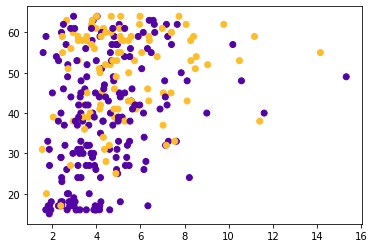

In [0]:
fig, ax = plt.subplots()
# add one line of code here to make a scatter plot
scatter = ax.scatter(X_train[:, 2], X_train[:, 7], c = y_train[:, 0], norm = plt.Normalize(-0.2, 1.2), cmap = plt.get_cmap('plasma'))
plt.show()